In [62]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from scipy.stats import spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import os

In [63]:
file_path = os.path.join('..', 'aggregated_data.csv')
data = pd.read_csv(file_path)

# inflation adjustment
base_cpi = data['CPI_US'].iloc[-1]
data['AVG_PRICE_AUCTION'] = data['AVG_PRICE_AUCTION'] * (base_cpi/data['CPI_US'])
data['CORN_FUTURES_TYPICAL_PRICE'] = data['CORN_FUTURES_TYPICAL_PRICE'] * (base_cpi/data['CPI_US'])
data['FEEDER_CATTLE_FUTURES_TYPICAL_PRICE'] = data['FEEDER_CATTLE_FUTURES_TYPICAL_PRICE'] * (base_cpi/data['CPI_US'])
data['US_MXN_RATES'] = data['US_MXN_RATES'] * (base_cpi/data['CPI_US'])
data['DIESEL_RETAIL_PRICE'] = data['DIESEL_RETAIL_PRICE'] * (base_cpi/data['CPI_US'])
data['DATE'] = pd.to_datetime(data['DATE'])

data = data.sort_values('DATE', ignore_index=True).set_index('DATE').drop( # drop columns not used for training
    ['avg_price_steers_ML1', 
     'avg_price_steers_ML1_2', 
     'avg_price_heifers_ML1', 
     'avg_price_heifers_ML1_2', 
     'NATIONAL_AUCTION_SALES', 
     'NATIONAL_TOTAL_SALES', 
     'TEXAS_AUCTION_SALES', 
     'CORN_FUTURES_TYPICAL_PRICE', 
     'DIESEL_RETAIL_PRICE', 
     'ALFAFA_HAY_PPI', 
     'CORN_PPI',
    #  'US_MXN_RATES',
     ], axis=1)


In [64]:
X = data.drop(['AVG_PRICE_AUCTION'], axis=1)
y = data['AVG_PRICE_AUCTION']

# # SPLIT DATA INTO 80/20 TRAINING TESTING SETS
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_size = int(len(data.index) * 0.9)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]


X_train = train_data.drop('AVG_PRICE_AUCTION', axis=1)
y_train = train_data['AVG_PRICE_AUCTION']
X_test = test_data.drop('AVG_PRICE_AUCTION', axis=1)
y_test = test_data['AVG_PRICE_AUCTION']

In [65]:
def evaluate_forecast(model_name, actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual,predicted)
    acc = 100.0 * (1 - mae / actual.mean()) if actual.mean() != 0 else float('nan')
    print(f"\n[{model_name}] Test Performance:")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}, Accuracy: {acc:.2f}%")

In [66]:
# CREATE AND TRAIN LINEAR REGRESSION MODEL
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lrg_train_pred = lin_reg.predict(X_train)
lrg_forecast_pred = lin_reg.predict(X_test)
residuals = y_test-lrg_forecast_pred
# EVALUATING MODEL PERFORMANCE
evaluate_forecast('Linear Regression: ', y_train, lrg_train_pred)
evaluate_forecast('Linear Regression: ', y_test, lrg_forecast_pred)


[Linear Regression: ] Test Performance:
MAE: 6.76, RMSE: 8.68, R²: 0.92, Accuracy: 96.37%

[Linear Regression: ] Test Performance:
MAE: 13.40, RMSE: 16.70, R²: -0.36, Accuracy: 94.96%


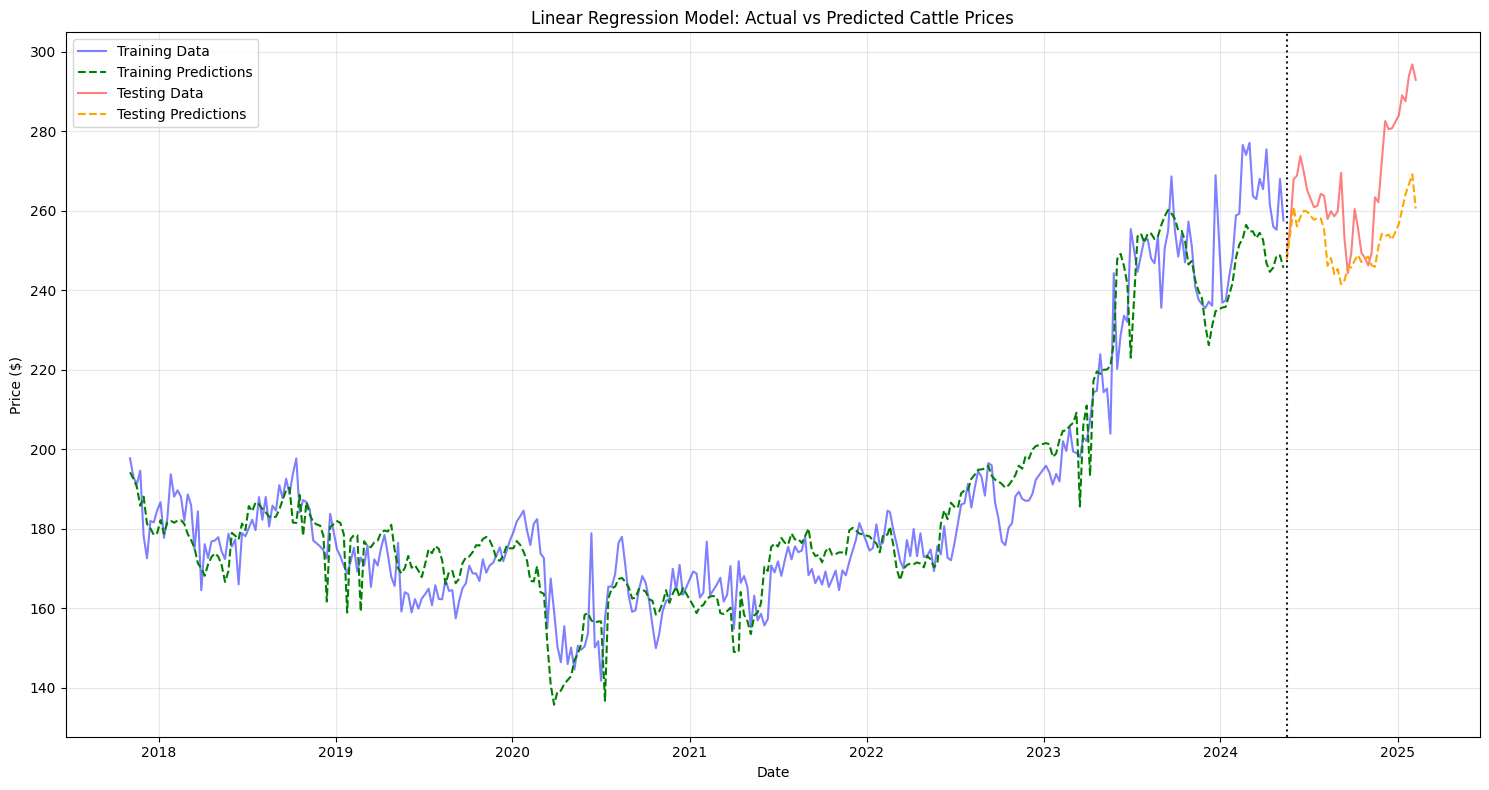

In [67]:
plt.figure(figsize=(15, 8))
plt.plot(y_train.index, y_train, label='Training Data', color='blue', alpha=0.5)
plt.plot(y_train.index, lrg_train_pred, label='Training Predictions', color='green', linestyle='--')

plt.plot(y_test.index, y_test, label='Testing Data', color='red', alpha=0.5)
plt.plot(y_test.index, lrg_forecast_pred, label='Testing Predictions', color='orange', linestyle='--')

# Customize plot
plt.title('Linear Regression Model: Actual vs Predicted Cattle Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.axvline(x=data.index[train_size], color='black', linestyle=':', alpha=0.9)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join('..', 'figures', 'linear_regression_plot.png'), dpi=300)
plt.show()